# Implementing Vi(sual)T(transformer) in PyTorch

Hi guys, happy new year! Today we are going to implement the famous **Vi**(sual)**T**(transformer) proposed in [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf).


Code is here, an interactive version of this article can be downloaded from [here](https://github.com/FrancescoSaverioZuppichini/ViT).

ViT will be soon available on my **new computer vision library called [glasses](https://github.com/FrancescoSaverioZuppichini/glasses)**

This is a technical tutorial, not your normal medium post where you find out about the top 5 secret pandas functions to make you rich. 

So, before beginning, I highly recommend you to:

- have a look at the amazing [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/) website
- watch [Yannic Kilcher video about ViT](https://www.youtube.com/watch?v=TrdevFK_am4&t=1000s)
- read the [Einops](https://einops.rocks/) doc

So, ViT uses a normal transformer (the one proposed in [Attention is All You Need](https://arxiv.org/abs/1706.03762)) that works on images. But, how?

The following picture shows ViT's architecture

![alt](./images/ViT.png)

The input image is decomposed into 16x16 flatten patches (the image is not in scale). Then they are embedded using a normal fully connected layer, a special `cls` token is added in front of them and the `positional encoding` is summed. The resulting tensor is passed first into a standard Transformer and then to a classification head. That's it. 

The article is structure into the following sections:

- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
- Head
- ViT

We are going to implement the model block by block with a bottom-up approach. We can start by importing all the required packages

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


Nothing fancy here, just PyTorch + stuff

## Data

First of all, we need a picture, a cute cat works just fine :)

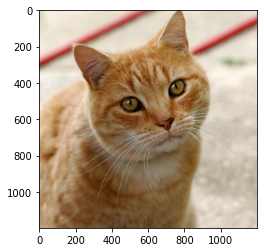

In [2]:
img = Image.open('./cat.jpg')

fig = plt.figure()
plt.imshow(img)

Then, we need to preprocess it

In [3]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

## Patches Embeddings

The first step is to break-down the image in multiple patches and flatten them.

![alt](./images/Patches.png)

Quoting from the paper:

![alt](./images/paper1.png)


This can be easily done using einops. 

In [4]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

Now, we need to project them using a normal linear layer

![alt](./images/PatchesProjected.png)

We can create a `PatchEmbedding` class to keep our code nice and clean

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)
        return x
    Position Embedding
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

### CLS Token

Next step is to add the `cls token` and the position embedding. The `cls token` is just a number placed in from of **each** sequence (of projected patches)

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

`cls_token` is a torch Parameter randomly initialized, in the `forward` method it is compied `b` (batch) times and preprended before the projected patches using `torch.cat`

### Position Embedding

So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape `N_PATCHES + 1 (token), EMBED_SIZE` that is added to the projected patches.

![alt](./images/PatchesPositionEmbedding.png)

In [29]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

We added the position embedding in the `.positions` field and sum it to the patches in the `.forward` function

## Transformer

Now we need the implement Transformer. In ViT only the Encoder is used, the architecture is visualized in the following picture.

<img src="./images/TransformerBlock.png" alt="drawing" width="200"/>

Let's start with the Attention part

### Attention

So, the attention takes three inputs, the famous **queries, keys and values** and compute the attention matrix using queries and values and use it to "attend" to the values. In this case, we are using **multi head** attention meaning that the computation is split across `n` heads with smaller input size.

![alt](./images/TransformerBlockAttention.png)

We can use `nn.MultiHadAttention` from PyTorch or implement our own. For completeness I will show how it looks like:

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

So, step by step. We have 4 fully connected layers, one for queries, keys, values, and a final one dropout.

Okay, the idea (really go and read [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/)) is to use the product between the queries and the keys to knowing "how much" each element is the sequence in important with the rest. Then, we use this information to scale the values.

The `forward` method takes as input the queries, keys, and values from the previous layer and projects them using the three linear layers. Since we implementing multi heads attention, we have to rearrange the result in multiple heads. 

This is done by using `rearrange` from einops. 

*Queries, Keys and Values* are always the same, so for simplicity, I have only one input (`x`). 

```python
queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.n_heads)
keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.n_heads)
values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.n_heads)
```

The resulting keys, queries, and values have a shape of `BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE`.

To compute the attention matrix we first have to perform matrix multiplication between queries and keys, a.k.a sum up over the last axis. This can be easily done using `torch.einsum`

```python
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys
```

The resulting vector has the shape `BATCH, HEADS, QUERY_LEN, KEY_LEN`. Then the attention is finally the softmax of the resulting vector divided by a scaling factor based on the size of the embedding. 

Lastly, we use the attention to scale the values

```python
torch.einsum('bhal, bhlv -> bhav ', att, values)
```

and we obtain a vector of size `BATCH HEADS VALUES_LEN, EMBEDDING_SIZE`. We concat the heads together and we finally return the results

### Residuals

The transformer block has residual connection

![alt](./images/TransformerBlockAttentionRes.png)

We can create a nice wrapper to perform the residual addition, it will be handy later on

In [30]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## MLP

The attention's output is passed to a fully connected layer composed by two layers that upsample by a factor of `expansion` the input

<img src="./images/TransformerBlockAttentionZoom.png" alt="drawing" width="200"/>


In [10]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

Just a quick side note. I don't know why but I've never seend people subclassing `nn.Sequential` to avoid writing the `forward` method. Start doing it, this is how object programming works!

**Finally** we can create the Transformer Encoder Block
<img src="./images/TransformerBlock.png" alt="drawing" width="200"/>


`ResidualAdd` allows us to define this block in an elegant way

In [11]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

Let's test it

In [12]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

you can also PyTorch build-in multi-head attention but it will expect 3 inputs: queries, keys, and values. You can subclass it and pass the same input

### Transformer

In ViT only the Encoder part of the original transformer is used. Easily, the encoder is `L` blocks of `TransformerBlock`.


In [25]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
                

Easy peasy!

## Head

The last layer is a normal fully connect that gives the class probability. It first performs a basic mean over the whole sequence.

![alt](./images/ClassificationHead.png)

In [31]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

## Vi(sual) T(rasnformer)

We can compose `PatchEmbedding`, `TransformerEncoder` and  `ClassificationHead` to create the final ViT architecture.

In [32]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

We can use `torchsummary` to check the number of parameters

In [28]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 196, 768]               0
            Linear-2             [-1, 196, 768]         590,592
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

(tensor(86415592), tensor(86415592), tensor(329.6493), tensor(694.5562))

et voilà

```
================================================================
Total params: 86,415,592
Trainable params: 86,415,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 364.33
Params size (MB): 329.65
Estimated Total Size (MB): 694.56
---------------------------------------------------------------
```

I checked the number of parameters with others implementation and they are the same!

# Conclusions

In this article, we have seen how to implement ViT in a nice, scalable and customizable way. I hope it was useful.

By the way, I am working on a **new computer vision library called [glasses](https://github.com/FrancescoSaverioZuppichini/glasses), check it out if you like**

Take care :)

Francesco